# Collaborative Filtering - Item based

    movie1   movie2    movie3 .... movie 10000
    5         3          5
    4         2          4
    5         3          5
    4         2          3
    3         4          4
    5         1          5


In [1]:
import time
#from tqdm import *
import random
from math import *
import operator
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

# following lib for matplot - core python plotting lib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

# seaborn plotting lib
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

In [14]:
# ml-20m
# location_movies  = r"E:\MYLEARN\2-ANALYTICS-DataScience\datasets\ml-20m\ml-20m\movies.csv"
# location_ratings = r"E:\MYLEARN\2-ANALYTICS-DataScience\datasets\ml-20m\ml-20m\ratings.csv"

In [2]:
# ml-small
location_movies  = r"E:\MYLEARN\2-ANALYTICS-DataScience\datasets\ml-latest-small\ml-latest-small\movies.csv"
location_ratings = r"E:\MYLEARN\2-ANALYTICS-DataScience\datasets\ml-latest-small\ml-latest-small\ratings.csv"

In [3]:
df_movies   = pd.read_csv(location_movies)
df_ratings  = pd.read_csv(location_ratings)

In [4]:
df_movies.shape, df_ratings.shape

((9742, 3), (100836, 4))

In [5]:
# first 5 movies
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# first few ratings
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# merge the movies and ratings dataframes, common column movieId
df = pd.merge(df_ratings, df_movies, on='movieId')

In [8]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [9]:
# dropping the genre column
df.drop(['genres'], axis=1, inplace=True)

In [10]:
df.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [11]:
# basic statistics
df.describe(include='all')

,userId,movieId,rating,timestamp,title
count,100836.000000,100836.000000,100836.000000,1.008360e+05,100836
unique,NaN,NaN,NaN,NaN,9719
top,NaN,NaN,NaN,NaN,Forrest Gump (1994)
freq,NaN,NaN,NaN,NaN,329
mean,326.127564,19435.295718,3.501557,1.205946e+09,NaN
std,182.618491,35530.987199,1.042529,2.162610e+08,NaN
min,1.000000,1.000000,0.500000,8.281246e+08,NaN
25%,177.000000,1199.000000,3.000000,1.019124e+09,NaN
50%,325.000000,2991.000000,3.500000,1.186087e+09,NaN
75%,477.000000,8122.000000,4.000000,1.435994e+09,NaN


create a dataframe with 
- the average rating for each movie and 
- the number of ratings. 

We are going to use these ratings to calculate the correlation between the movies later.

In [12]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [13]:
type(ratings)

pandas.core.frame.DataFrame

- Calculate number of ratings for each movie. 

    - We do this by creating a number_of_ratings column. 

    - This is important so that we can see the relationship between the average rating of a movie and the number of ratings the movie got. 

    - It is very possible that a 5 star movie was rated by just one person. 

    - It is therefore statistically incorrect to classify that movie has a 5 star movie. 
    - We will therefore need to set a threshold for the minimum number of ratings as we build the recommender system.

In [13]:
ratings['number_of_ratings'] = df.groupby('title')['rating'].count()
ratings.sample(10)

,rating,number_of_ratings
title,,
Private Resort (1985),1.500000,1
"Color of Money, The (1986)",3.500000,13
It's a Very Merry Muppet Christmas Movie (2002),1.500000,2
Son of Rambow (2007),4.666667,3
Jimmy Carr: Telling Jokes (2009),4.000000,1
Vera Drake (2004),3.000000,4
Red Beard (Akahige) (1965),4.500000,1
"Wedding Date, The (2005)",3.136364,11
"Little Girl Who Lives Down the Lane, The (1976)",4.000000,1


In [14]:
ratings.describe()

,rating,number_of_ratings
count,9719.000000,9719.000000
mean,3.262388,10.375141
std,0.870004,22.406220
min,0.500000,1.000000
25%,2.800000,1.000000
50%,3.416667,3.000000
75%,3.910357,9.000000
max,5.000000,329.000000


Plot a Histogram using pandas plotting functionality to visualize the distribution of the ratings

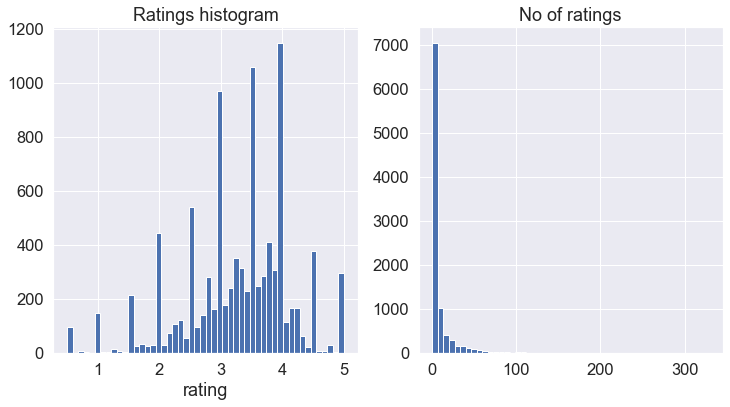

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
ratings['rating'].hist(bins=50);
plt.title('Ratings histogram')
plt.xlabel('rating')

plt.subplot(122)
ratings['number_of_ratings'].hist(bins=50);
plt.title('No of ratings');

most of the movies are rated between 2.5 and 4.

most movies have few ratings. Movies with most ratings are those that are most famous.

check the relationship between the rating of a movie and the number of ratings.

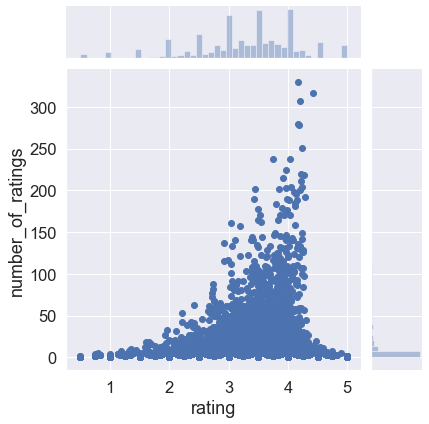

In [16]:
sns.jointplot(x='rating', y='number_of_ratings', data=ratings);

their is a positive relationship between the average rating of a movie and the number of ratings. 

The graph indicates that the higher rating a movie gets, the higher the number of ratings 

# item based recommender system

- convert our dataset into a matrix 
    - with the movie titles as the columns, 
    - the user_id as the index and 
    - the ratings as the values.
   
- By doing this we shall get a dataframe with the columns as the movie titles and the rows as the user ids

- Each column represents all the ratings of a movie by all users.

In [23]:
df.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


#### understanding ... pandas pivot table

In [24]:
df_pivot = pd.read_excel(r"E:\MYLEARN\2-ANALYTICS-DataScience\datasets\sales-funnel.xlsx")
df_pivot.head()    

,Account,Name,Rep,Manager,Product,Quantity,Price,Status
0,714466,Trantow-Barrows,Craig Booker,Debra Henley,CPU,1,30000,presented
1,714466,Trantow-Barrows,Craig Booker,Debra Henley,Software,1,10000,presented
2,714466,Trantow-Barrows,Craig Booker,Debra Henley,Maintenance,2,5000,pending
3,737550,"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,CPU,1,35000,declined
4,146832,Kiehn-Spinka,Daniel Hilton,Debra Henley,CPU,2,65000,won


In [25]:
df_pivot.shape

(17, 8)

In [26]:
df_pivot.sort_values(['Manager', 'Rep'])

,Account,Name,Rep,Manager,Product,Quantity,Price,Status
0,714466,Trantow-Barrows,Craig Booker,Debra Henley,CPU,1,30000,presented
1,714466,Trantow-Barrows,Craig Booker,Debra Henley,Software,1,10000,presented
2,714466,Trantow-Barrows,Craig Booker,Debra Henley,Maintenance,2,5000,pending
3,737550,"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,CPU,1,35000,declined
4,146832,Kiehn-Spinka,Daniel Hilton,Debra Henley,CPU,2,65000,won
5,218895,Kulas Inc,Daniel Hilton,Debra Henley,CPU,2,40000,pending
6,218895,Kulas Inc,Daniel Hilton,Debra Henley,Software,1,10000,presented
7,412290,Jerde-Hilpert,John Smith,Debra Henley,Maintenance,2,5000,pending
8,740150,Barton LLC,John Smith,Debra Henley,CPU,1,35000,declined
9,141962,Herman LLC,Cedric Moss,Fred Anderson,CPU,2,65000,won


In [27]:
df_pivot["Status"] = df_pivot["Status"].astype("category")
df_pivot["Status"].cat.set_categories(["won", "pending", "presented", "declined"], inplace=True)

In [28]:
# simplest pivot table must have a dataframe and an index . In this case, let’s use the Name as our index.

pd.pivot_table(df_pivot, index=["Name"])

,Account,Price,Quantity
Name,,,
Barton LLC,740150,35000,1.000000
"Fritsch, Russel and Anderson",737550,35000,1.000000
Herman LLC,141962,65000,2.000000
Jerde-Hilpert,412290,5000,2.000000
"Kassulke, Ondricka and Metz",307599,7000,3.000000
Keeling LLC,688981,100000,5.000000
Kiehn-Spinka,146832,65000,2.000000
Koepp Ltd,729833,35000,2.000000
Kulas Inc,218895,25000,1.500000


You can have multiple indexes as well. 

In fact, most of the pivot_table args can take multiple values via a list.

In [23]:
pd.pivot_table(df_pivot, index=["Manager", "Rep"])

Account         Price  Quantity
Manager       Rep                                            
Debra Henley  Craig Booker   720237.0  20000.000000  1.250000
              Daniel Hilton  194874.0  38333.333333  1.666667
              John Smith     576220.0  20000.000000  1.500000
Fred Anderson Cedric Moss    196016.5  27500.000000  1.250000
              Wendy Yule     614061.5  44250.000000  3.000000

You can see that the pivot table is smart enough to start aggregating the data and summarizing it by grouping the reps with their managers. 

the Account and Quantity columns aren’t really useful. Let’s remove it by explicitly defining the columns we care about using the values field.

In [24]:
pd.pivot_table(df_pivot, index=["Manager", "Rep"], values=["Price"])

Price
Manager       Rep                        
Debra Henley  Craig Booker   20000.000000
              Daniel Hilton  38333.333333
              John Smith     20000.000000
Fred Anderson Cedric Moss    27500.000000
              Wendy Yule     44250.000000

The price column automatically averages the data but we can do a count or a sum.

In [29]:
pd.pivot_table(df_pivot, 
               index=["Manager","Rep"], 
               values=["Price"], 
               aggfunc=np.sum)

Price
Manager       Rep                  
Debra Henley  Craig Booker    80000
              Daniel Hilton  115000
              John Smith      40000
Fred Anderson Cedric Moss    110000
              Wendy Yule     177000

aggfunc can take a list of functions. Let’s try a mean using the numpy mean function and len to get a count.

In [27]:
pd.pivot_table(df_pivot, 
               index=["Manager","Rep"], 
               values=["Price"],
               aggfunc=[np.sum, np.mean, len])

sum          mean   len
                              Price         Price Price
Manager       Rep                                      
Debra Henley  Craig Booker    80000  20000.000000     4
              Daniel Hilton  115000  38333.333333     3
              John Smith      40000  20000.000000     2
Fred Anderson Cedric Moss    110000  27500.000000     4
              Wendy Yule     177000  44250.000000     4

If we want to see sales broken down by the products, the __columns__ variable allows us to define one or more columns.

The aggregation functions are applied to the values you list.

In [30]:
pd.pivot_table(df_pivot,
               index  =["Manager", "Rep"],
               values =["Price"],
               columns=["Product"],
               aggfunc=[np.sum])

sum                             
                                Price                             
Product                           CPU Maintenance Monitor Software
Manager       Rep                                                 
Debra Henley  Craig Booker    65000.0      5000.0     NaN  10000.0
              Daniel Hilton  105000.0         NaN     NaN  10000.0
              John Smith      35000.0      5000.0     NaN      NaN
Fred Anderson Cedric Moss     95000.0      5000.0     NaN  10000.0
              Wendy Yule     165000.0      7000.0  5000.0      NaN

Add Quantity to the values list.

In [31]:
pd.pivot_table(df_pivot,
               index   =["Manager","Rep"],
               values  =["Price","Quantity"],
               columns =["Product"],
               aggfunc =[np.sum],
               fill_value=0)

sum                                        \
                              Price                              Quantity   
Product                         CPU Maintenance Monitor Software      CPU   
Manager       Rep                                                           
Debra Henley  Craig Booker    65000        5000       0    10000        2   
              Daniel Hilton  105000           0       0    10000        4   
              John Smith      35000        5000       0        0        1   
Fred Anderson Cedric Moss     95000        5000       0    10000        3   
              Wendy Yule     165000        7000    5000        0        7   

                                                          
                                                          
Product                     Maintenance Monitor Software  
Manager       Rep                                         
Debra Henley  Craig Booker            2       0        1  
              Daniel Hilton           0       0        1  
              John Smith              2       0        0  
Fred Anderson Cedric Moss             1       0        1  
              Wendy Yule              3       2        0

Remove Product from the columns and add to the index .

In [32]:
pd.pivot_table(df_pivot,
               index   =["Manager","Rep","Product"],
               values  =["Price","Quantity"],
               aggfunc =[np.sum],
               fill_value=0)

sum         
                                          Price Quantity
Manager       Rep           Product                     
Debra Henley  Craig Booker  CPU           65000        2
                            Maintenance    5000        2
                            Software      10000        1
              Daniel Hilton CPU          105000        4
                            Software      10000        1
              John Smith    CPU           35000        1
                            Maintenance    5000        2
Fred Anderson Cedric Moss   CPU           95000        3
                            Maintenance    5000        1
                            Software      10000        1
              Wendy Yule    CPU          165000        7
                            Maintenance    7000        3
                            Monitor        5000        2

Now, what if I want to see some totals? margins=True does that for us.

In [33]:
pd.pivot_table(df_pivot,
               index  =["Manager","Rep","Product"],
               values =["Price","Quantity"],
               aggfunc=[np.sum,np.mean],
               fill_value=0,
               margins=True)

sum            mean          
                                          Price Quantity  Price  Quantity
Manager       Rep           Product                                      
Debra Henley  Craig Booker  CPU           65000        2  32500  1.000000
                            Maintenance    5000        2   5000  2.000000
                            Software      10000        1  10000  1.000000
              Daniel Hilton CPU          105000        4  52500  2.000000
                            Software      10000        1  10000  1.000000
              John Smith    CPU           35000        1  35000  1.000000
                            Maintenance    5000        2   5000  2.000000
Fred Anderson Cedric Moss   CPU           95000        3  47500  1.500000
                            Maintenance    5000        1   5000  1.000000
                            Software      10000        1  10000  1.000000
              Wendy Yule    CPU          165000        7  82500  3.500000
                            Maintenance    7000        3   7000  3.000000
                            Monitor        5000        2   5000  2.000000
All                                      522000       30  30705  1.764706

Analysis at the manager level. 

Notice how the status is ordered based on our earlier category definition.

In [34]:
pd.pivot_table(df_pivot,
               index  =["Manager","Status"],
               values =["Price"],
               aggfunc=[np.sum],
               fill_value=0,
               margins=True)

sum
                          Price
Manager       Status           
Debra Henley  won         65000
              pending     50000
              presented   50000
              declined    70000
Fred Anderson won        172000
              pending      5000
              presented   45000
              declined    65000
All                      522000

A really handy feature is the ability to pass a dictionary to the aggfunc so you can perform different functions on each of the values you select. 

In [35]:
pd.pivot_table(df_pivot,
               index  =["Manager","Status"],
               columns=["Product"],
               values =["Quantity","Price"],
               aggfunc={"Quantity":len, "Price":np.sum},
               fill_value=0)

Price                              Quantity  \
Product                     CPU Maintenance Monitor Software      CPU   
Manager       Status                                                    
Debra Henley  won         65000           0       0        0        1   
              pending     40000       10000       0        0        1   
              presented   30000           0       0    20000        1   
              declined    70000           0       0        0        2   
Fred Anderson won        165000        7000       0        0        2   
              pending         0        5000       0        0        0   
              presented   30000           0    5000    10000        1   
              declined    65000           0       0        0        1   

                                                      
Product                 Maintenance Monitor Software  
Manager       Status                                  
Debra Henley  won                 0       0        0  
              pending             2       0        0  
              presented           0       0        2  
              declined            0       0        0  
Fred Anderson won                 1       0        0  
              pending             1       0        0  
              presented           0       1        1  
              declined            0       0        0

You can provide a list of aggfunctions to apply to each value too:

In [36]:
pd.pivot_table(df_pivot,
               index   =["Manager","Status"],
               columns =["Product"],
               values  =["Quantity","Price"],
               aggfunc ={"Quantity":len,"Price":[np.sum,np.mean]},
               fill_value=0)

Price                                       \
                          mean                                  sum   
Product                    CPU Maintenance Monitor Software     CPU   
Manager       Status                                                  
Debra Henley  won        65000           0       0        0   65000   
              pending    40000        5000       0        0   40000   
              presented  30000           0       0    10000   30000   
              declined   35000           0       0        0   70000   
Fred Anderson won        82500        7000       0        0  165000   
              pending        0        5000       0        0       0   
              presented  30000           0    5000    10000   30000   
              declined   65000           0       0        0   65000   

                                                     Quantity              \
                                                          len               
Product                 Maintenance Monitor Software      CPU Maintenance   
Manager       Status                                                        
Debra Henley  won                 0       0        0        1           0   
              pending         10000       0        0        1           2   
              presented           0       0    20000        1           0   
              declined            0       0        0        2           0   
Fred Anderson won              7000       0        0        2           1   
              pending          5000       0        0        0           1   
              presented           0    5000    10000        1           0   
              declined            0       0        0        1           0   

                                          
                                          
Product                 Monitor Software  
Manager       Status                      
Debra Henley  won             0        0  
              pending         0        0  
              presented       0        2  
              declined        0        0  
Fred Anderson won             0        0  
              pending         0        0  
              presented       1        1  
              declined        0        0

... back to the main code

In [17]:
movie_matrix = df.pivot_table(index  ='userId', 
                              columns='title', 
                              values ='rating')
movie_matrix.shape

(610, 9719)

In [18]:
movie_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next let’s look at the most rated movies and choose 2 of them to work with in this simple recommender system. 

In [19]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


Let’s assume that a user has watched 
- Air Force One (1997) and 
- Contact (1997). 

We would like like to recommend movies to this user based on this watching history. 

- The goal is to look for movies that are similar to Contact (1997) and Air Force One (1997 which we shall recommend to this user. 

- We can achieve this by computing the __correlation__ between these two movies’ ratings and the ratings of the rest of the movies in the dataset. 

In [20]:
# extract ratings for the 2 movies. Ratings by all users
AFO_user_rating     = movie_matrix['Air Force One (1997)']
contact_user_rating = movie_matrix['Contact (1997)']

In [21]:
print(AFO_user_rating.shape, contact_user_rating.shape)
print(contact_user_rating.shape, contact_user_rating.shape)

(610,) (610,)
(610,) (610,)


In [22]:
type(AFO_user_rating), type(contact_user_rating)

(pandas.core.series.Series, pandas.core.series.Series)

In [24]:
AFO_user_rating.sample(6)

userId
285   NaN
257   NaN
532   NaN
581   NaN
143   NaN
276   NaN
Name: Air Force One (1997), dtype: float64

In [25]:
contact_user_rating.sample(6)

userId
407   NaN
51    NaN
72    NaN
30    NaN
554   NaN
336   NaN
Name: Contact (1997), dtype: float64

get the __correlation__ between each movie's rating and the ratings of the Air Force One movie.

In [36]:
movie_matrix.shape

(610, 9719)

... explanation of PANDAS __corrwith__ and __corr__

In [26]:
# Creating the first dataframe 
df1 = pd.DataFrame({"A":[1, 5, 7, 8],  
                    "B":[5, 8, 4, 3], 
                    "C":[10, 4, 9, 3]}) 
  
# Creating the second dataframe  
df2 = pd.DataFrame({"A":[5, 3, 6, 4], 
                    "B":[11, 2, 4, 3], 
                    "C":[4, 3, 8, 5]}) 

In [32]:
# np.random.seed(123)
# df1=pd.DataFrame( np.random.randn(3,2), columns=list('ab') )
# df2=pd.DataFrame( np.random.randn(3,2), columns=list('ac') )

In [27]:
df1.corr()

,A,B,C
A,1.000000,-0.398756,-0.597881
B,-0.398756,1.000000,-0.131812
C,-0.597881,-0.131812,1.000000


In [28]:
df1

,A,B,C
0,1,5,10
1,5,8,4
2,7,4,9
3,8,3,3


In [29]:
df2

,A,B,C
0,5,11,4
1,3,2,3
2,6,4,8
3,4,3,5


You can compare columns of df1 & df2 with corrwith. Note that only columns with the same names are compared:

In [30]:
# To find the correlation among the 
# columns of df1 and df2 along the row axis 
df1.corrwith(df2)

A   -0.041703
B   -0.151186
C    0.395437
dtype: float64

In [37]:
# unequal columns

In [31]:
# Creating the first dataframe 
df1 = pd.DataFrame({"A":[1, 5, 7, 8],  
                    "B":[5, 8, 4, 3], 
                    "C":[10, 4, 9, 3]}) 
  
# Creating the second dataframe  
df2 = pd.DataFrame({"A":[5, 3, 6, 4], 
}) 

In [32]:
df1.corrwith(df2)

A   -0.041703
B         NaN
C         NaN
dtype: float64

In [50]:
# Creating the first dataframe 
df1 = pd.DataFrame({"A":[1, 5, 7, 8],  
                    "B":[5, 8, 4, 3], 
                    "C":[10, 4, 9, 3]}) 
  
# Creating the second dataframe  
sr =  pd.Series([5, 3, 6, 4]
) 

In [51]:
# series should be inside the bracket. As corrwith is a function 
# of a dataframe not series
df1.corrwith(sr)

A   -0.041703
B   -0.597614
C    0.808736
dtype: float64

.. back to main code .

In [33]:
similar_to_air_force_one=movie_matrix.corrwith(AFO_user_rating)

C:\Users\admin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\admin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [34]:
type(similar_to_air_force_one)

pandas.core.series.Series

In [35]:
similar_to_air_force_one.sample(10)

title
Gothika (2003)                       NaN
After Hours (1985)                   NaN
Fort Tilden (2014)                   NaN
Meet Wally Sparks (1997)             1.0
Insomnia (1997)                      NaN
Day of Wrath (Vredens dag) (1943)    NaN
Wrath of the Titans (2012)           NaN
John Carter (2012)                   0.0
Ladybird Ladybird (1994)             NaN
Flirting With Disaster (1996)        NaN
dtype: float64

compute the correlation between Contact (1997) ratings and the rest of the movies ratings.

In [36]:
similar_to_contact = movie_matrix.corrwith(contact_user_rating)

In [37]:
similar_to_contact.sample(10)

title
Villain (1971)                                          NaN
Jack-Jack Attack (2005)                                 NaN
Nights of Cabiria (Notti di Cabiria, Le) (1957)         NaN
Event Horizon (1997)                              -0.447840
Ghosts of Girlfriends Past (2009)                       NaN
If These Walls Could Talk 2 (2000)                      NaN
High Anxiety (1977)                                     NaN
Hurricane Streets (1997)                                NaN
Gray's Anatomy (1996)                              1.000000
Cat's Eye (1985)                                   0.147442
dtype: float64

As noticed earlier our matrix had very many missing values since not all the movies were rated by all the users. We therefore drop those null values and transform correlation results into dataframes to make the results look more appealing.

In [38]:
corr_contact = pd.DataFrame(similar_to_contact, columns=['Correlation'])
corr_contact.dropna(inplace=True)
corr_contact.head()

,Correlation
title,
"'burbs, The (1989)",0.486761
(500) Days of Summer (2009),0.634064
*batteries not included (1987),0.868599
...And Justice for All (1979),1.000000
10 Things I Hate About You (1999),-0.102640


In [39]:
corr_AFO = pd.DataFrame(similar_to_air_force_one, columns=['correlation'])
corr_AFO.dropna(inplace=True)
corr_AFO.head()

,correlation
title,
"'burbs, The (1989)",0.168459
(500) Days of Summer (2009),0.086874
*batteries not included (1987),-0.866025
10 Cloverfield Lane (2016),0.192450
10 Items or Less (2006),-1.000000


These two dataframes above show us the movies that are most similar to Contact (1997) and Air Force One (1997) movies respectively. 

In [40]:
corr_AFO.sort_values(['correlation'], ascending=False)

,correlation
title,
Kissing Jessica Stein (2001),1.0
"Kid in King Arthur's Court, A (1995)",1.0
Shampoo (1975),1.0
Domino (2005),1.0
Reign Over Me (2007),1.0
Ghost Dad (1990),1.0
Alien: Covenant (2017),1.0
"Chamber, The (1996)",1.0
Larry Crowne (2011),1.0


However we have a challenge in that some of the movies have very few ratings and may end up being recommended simply because one or two people gave them a 5 star rating. 

We can fix this by setting a threshold for the number of ratings. 